In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [3]:
data = pd.read_csv('store-sales-time-series-forecasting/train.csv')
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
# Information sur la base de données
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
# Conversion de la date en datetime
from datetime import datetime
data['date']=pd.to_datetime(data['date'],infer_datetime_format=True)
data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
# Verification
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [7]:
# Mettre la date en index de la table
data.set_index('date',inplace=True)
data.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [8]:
# Agrégation des ventes par date
daily_sales = data.groupby(data.index)[['sales']].sum()
len(daily_sales)

1684

In [9]:
# Vérification des valeurs manquante
daily_sales.isnull().sum()

sales    0
dtype: int64

In [10]:
daily_sales = daily_sales.asfreq('d')

In [11]:
daily_sales.isnull().sum()

sales    4
dtype: int64

In [12]:
daily_sales.ffill(inplace=True)

### Etape 1: Identification du modèle

#### Analyse des données

##### Représentation graphique

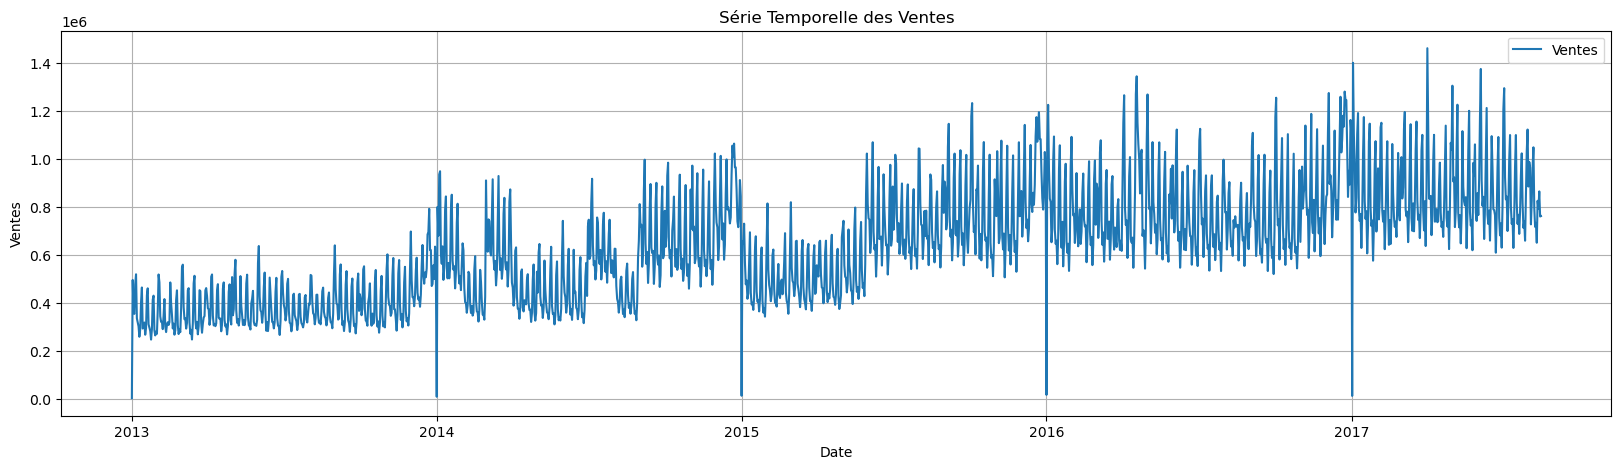

In [13]:
# Visualisation de la série temporelle
plt.figure(figsize=(20, 5))
plt.plot(daily_sales, label='Ventes')
plt.title('Série Temporelle des Ventes')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid()
plt.show()

<Axes: xlabel='sales', ylabel='Count'>

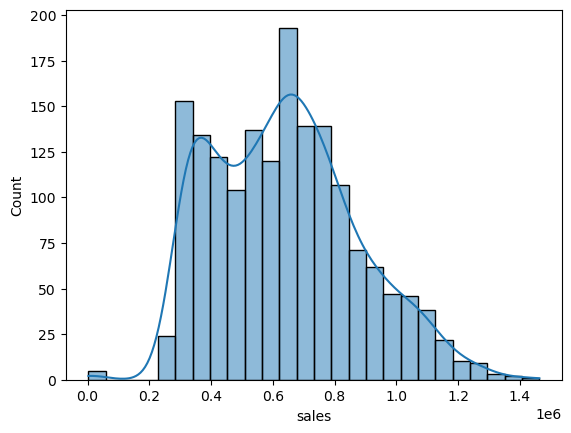

In [14]:
# verifier si la distribution est normale
sns.histplot(daily_sales, x="sales", kde=True)

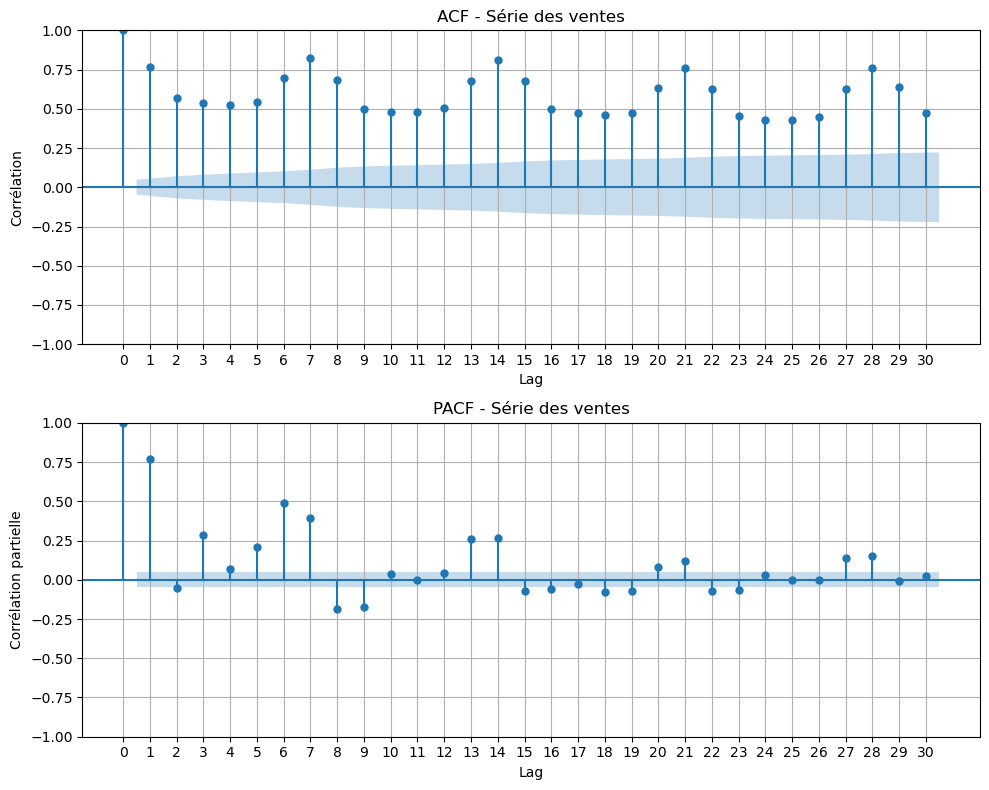

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(daily_sales['sales'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série des ventes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(daily_sales['sales'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série des ventes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

In [16]:
# Analyse de la stationnarité de la variable
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(daily_sales['sales'])

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | -2.623339337385241            |
| P-valeur       | 0.08826880168432555           |
| Conclusion     | La série est non stationnaire |


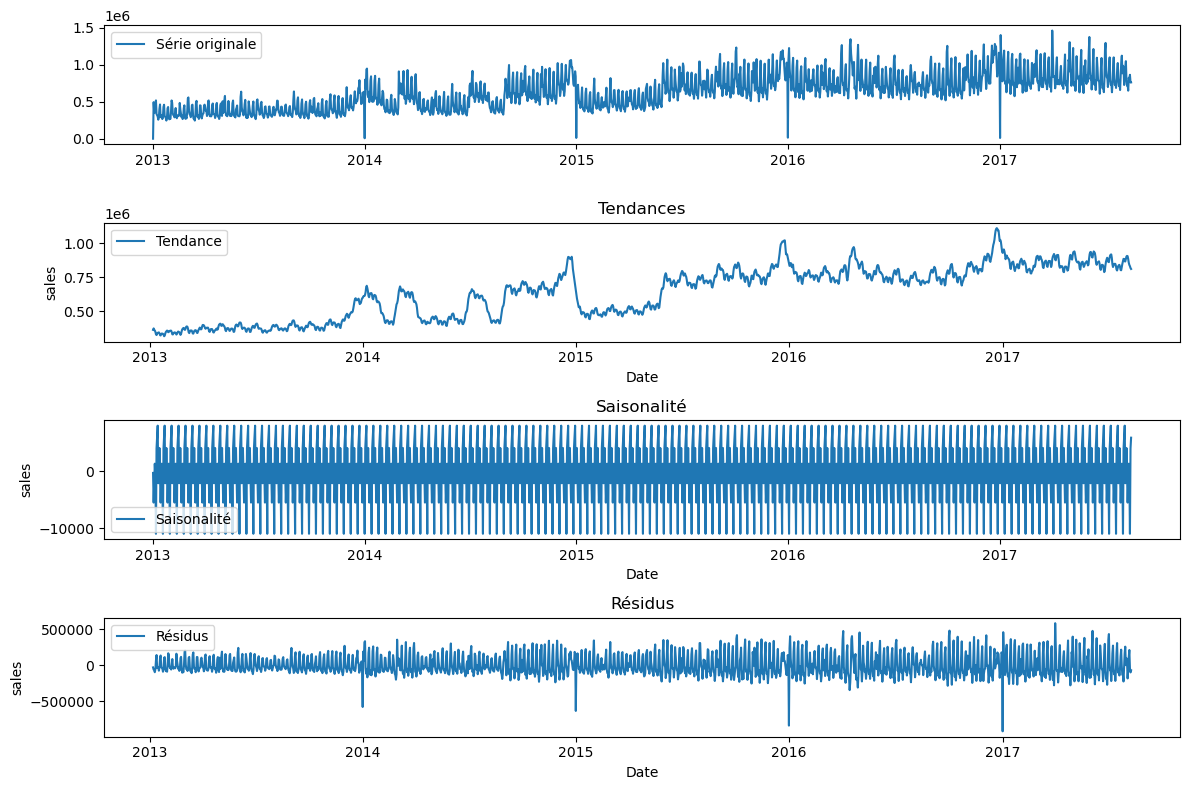

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition de la série temporelle
decomposition = seasonal_decompose(daily_sales['sales'], model='additive', period=12)  # Ajustez le 'period' selon vos données

# Extraire les composants
tendance = decomposition.trend
saisonalite = decomposition.seasonal
residus = decomposition.resid

plt.figure(figsize=(12, 8))

# La serie
plt.subplot(411)
plt.plot(daily_sales, label='Série originale')
plt.legend(loc='best')

# Tracer les tendances
plt.subplot(412)
plt.plot(tendance, label='Tendance')
plt.title('Tendances')
plt.xlabel('Date')
plt.ylabel('sales')
plt.legend(loc='best')

# Tracer la saisonnalité
plt.subplot(413)
plt.plot(saisonalite, label='Saisonalité')
plt.title('Saisonalité')
plt.xlabel('Date')
plt.ylabel('sales')
plt.legend(loc='best')

# Tracer les résidus
plt.subplot(414)
plt.plot(residus, label='Résidus')
plt.title('Résidus')
plt.xlabel('Date')
plt.ylabel('sales')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


#### Rendons la serie stationnaire

#### Différentciation (Stationnarisation)

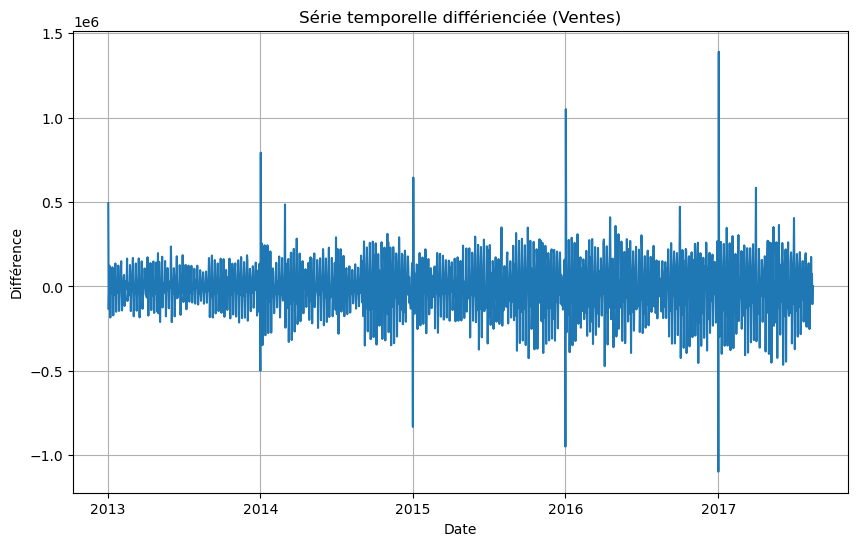

In [18]:
# Différenciation pour rendre la série stationnaire
differenced = daily_sales['sales'].diff().dropna()

# Afficher la série différienciée
plt.figure(figsize=(10, 6))
plt.plot(differenced)
plt.title('Série temporelle différienciée (Ventes)')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

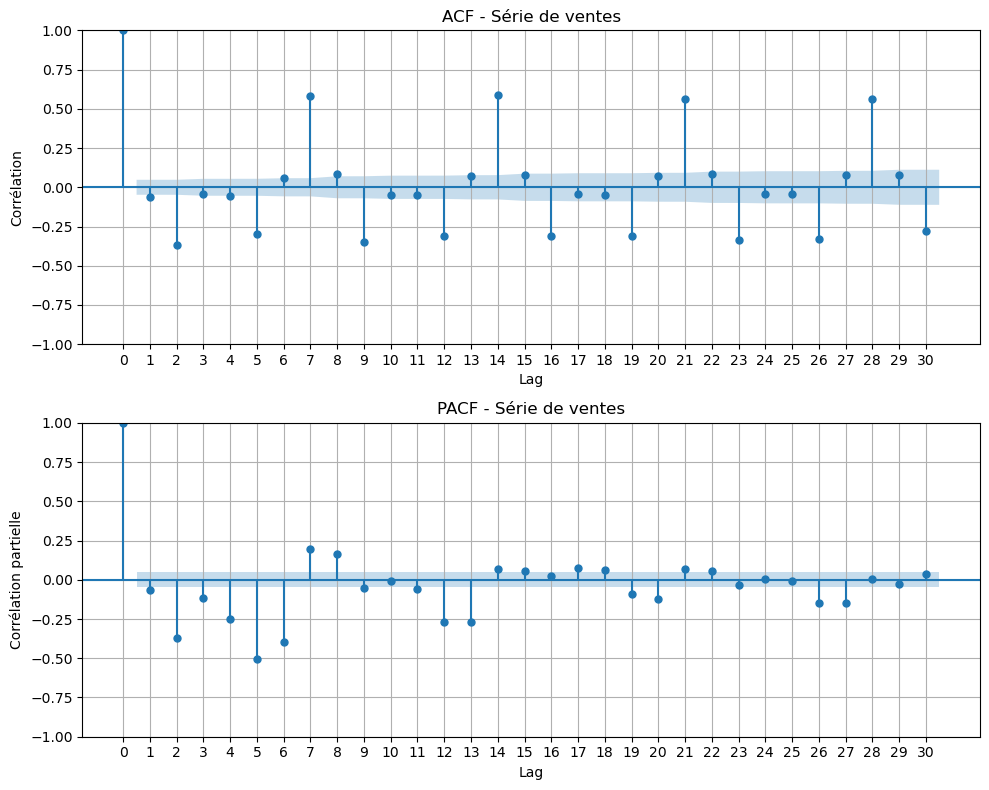

In [19]:
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF - Série de ventes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF - Série de ventes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

In [20]:
# Analyse de la stationnarité de la variable
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -11.351129014297998       |
| P-valeur       | 9.988955399785768e-21     |
| Conclusion     | La série est stationnaire |


#### Identification de l'ordre p,d,q

In [21]:
p=5 # Le premier lag où la PACF devient non significatif (PACF)
d=1 # l'ordre de différenciation: détermine combien de fois la série doit être différenciée pour devenir stationnaire. 
q=5 # Le premier lag où l'ACF devient non significatif (l'ACF)

In [22]:
# Séparer les données en ensemble d'entraînement et ensemble de test
size = int(len(daily_sales)*80/100)
train_data, test_data = daily_sales.iloc[:size], daily_sales.iloc[size:]

#### Estimation du modèle

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# Créer un modèle ARIMA
model = ARIMA(train_data, order=(p, d, q))

# Ajuster le modèle
model_fit = model.fit()

# Afficher le résumé du modèle
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1350
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -17300.980
Date:                Wed, 14 Aug 2024   AIC                          34623.959
Time:                        08:54:39   BIC                          34681.238
Sample:                    01-01-2013   HQIC                         34645.411
                         - 09-11-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3877      0.088      4.388      0.000       0.215       0.561
ar.L2         -1.1003      0.071    -15.449      0.000      -1.240      -0.961
ar.L3          0.2195      0.125      1.749      0.0

### Vérification du modèle

#### Graphiques des résidus

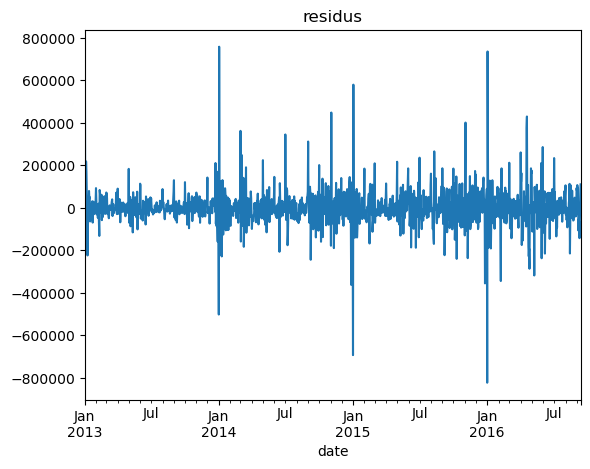

<Figure size 2000x500 with 0 Axes>

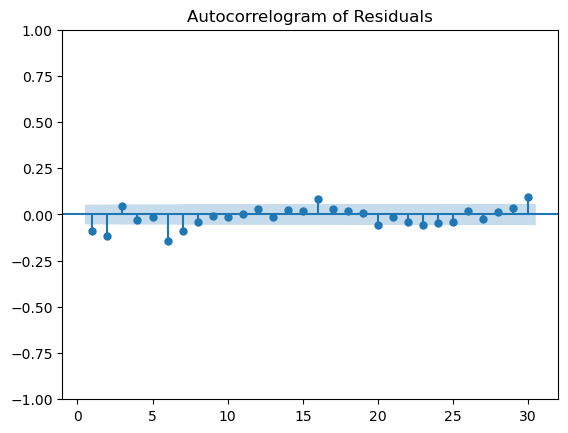

<Figure size 2000x500 with 0 Axes>

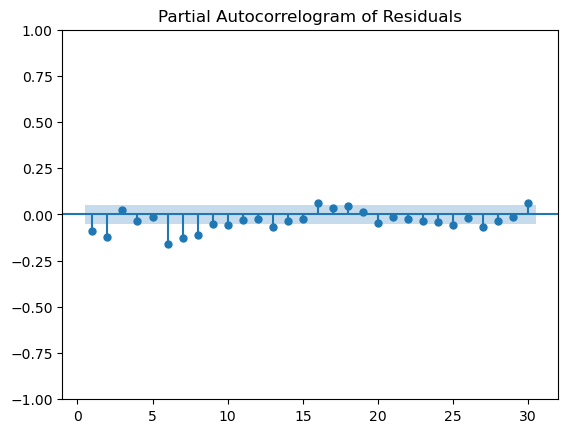

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les résidus
residuals = model_fit.resid

# Tracer les residus
residuals.plot()
plt.title('residus')
plt.show()

# Tracer l'ACF des résidus
plt.figure(figsize=(20, 5))
plot_acf(residuals, lags=30, zero=False)
plt.title("Autocorrelogram of Residuals")
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(20, 5))
plot_pacf(residuals, lags=30, zero=False)
plt.title("Partial Autocorrelogram of Residuals")
plt.show()

### Prédiction

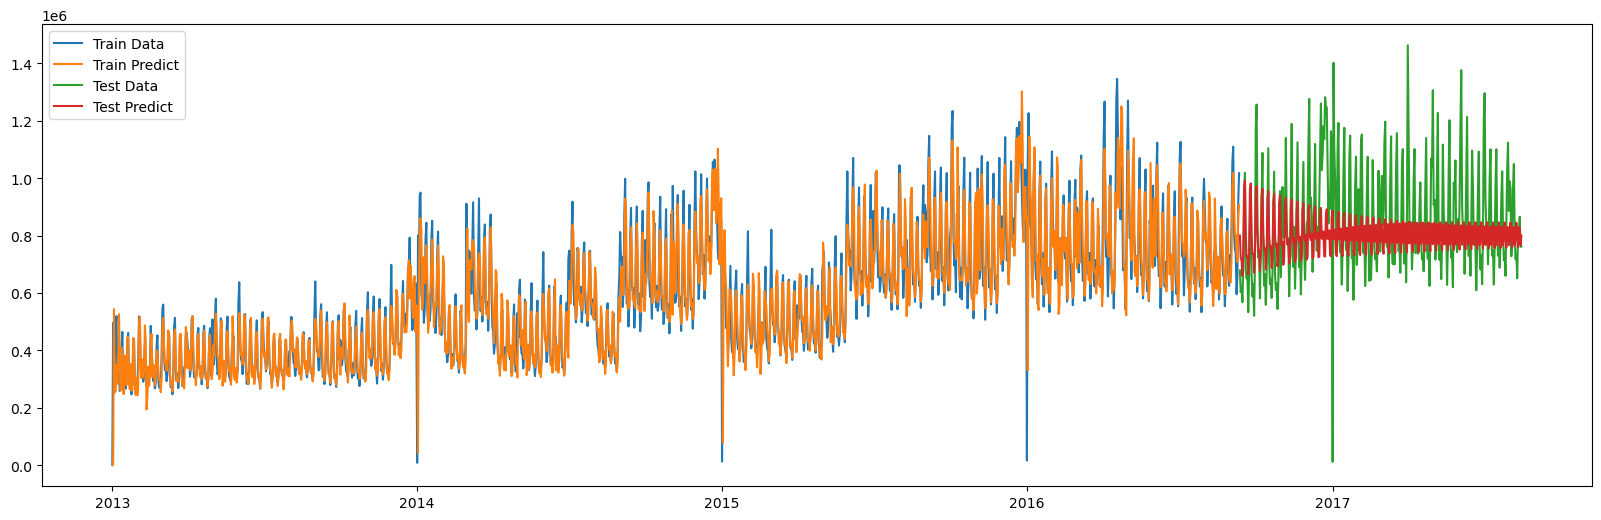

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_predict = model_fit.predict(start=train_data.index[0], end=train_data.index[-1])

test_predict = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(20, 6))
plt.plot(train_data['sales'], label='Train Data')
plt.plot(train_predict, label='Train Predict')
plt.plot(test_data['sales'], label='Test Data')
plt.plot(test_predict, label='Test Predict')
plt.legend()
plt.show()

In [26]:
test_predict

2016-09-12    800315.645138
2016-09-13    721938.109810
2016-09-14    714800.173822
2016-09-15    659270.765558
2016-09-16    740381.175993
                  ...      
2017-08-11    759788.498700
2017-08-12    829688.888874
2017-08-13    827904.240351
2017-08-14    766803.474133
2017-08-15    800594.330797
Freq: D, Name: predicted_mean, Length: 338, dtype: float64

In [27]:
print(f'Longueur de train_data: {len(train_data)}')
print(f'Longueur de train_predictions: {len(train_predict)}')

Longueur de train_data: 1350
Longueur de train_predictions: 1350


#### Evaluation du modele

In [28]:
# Mesures de performance sur l'ensemble d'entraînement
train_mae = mean_absolute_error(train_data, train_predict)
train_mse = mean_squared_error(train_data, train_predict)
train_rmse = mean_squared_error(train_data, train_predict, squared=False)
train_r2 = r2_score(train_data, train_predict)

# Mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_data, test_predict)
test_mse = mean_squared_error(test_data, test_predict)
test_rmse = mean_squared_error(test_data, test_predict, squared=False)
test_r2 = r2_score(test_data, test_predict)

# Créer un DataFrame pour afficher les mesures de performance
performance_df = pd.DataFrame({
    'Métrique': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble d\'entraînement': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test': [test_mae, test_mse, test_rmse, test_r2]
})

print(performance_df)

  Métrique  Ensemble d'entraînement  Ensemble de test
0      MAE             5.435648e+04      1.220873e+05
1      MSE             8.060758e+09      2.846703e+10
2     RMSE             8.978172e+04      1.687218e+05
3       R²             8.262257e-01      1.827607e-01


In [29]:
df_test_final = pd.read_csv("store-sales-time-series-forecasting/test.csv")
df_test_final.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [30]:
df_test_final = df_test_final.groupby('date')[['id']].mean()
df_test_final.shape

(16, 1)

In [31]:
predictions = model_fit.predict(start=df_test_final.index[0], end=df_test_final.index[-1])

type(predictions)

pandas.core.series.Series

In [32]:
df_test_final['sales'] = predictions[1]

In [33]:
df_test_final.head()

,id,sales
date,,
2017-08-16,3001778.5,784710.717446
2017-08-17,3003560.5,784710.717446
2017-08-18,3005342.5,784710.717446
2017-08-19,3007124.5,784710.717446
2017-08-20,3008906.5,784710.717446


In [34]:
df_test_final.to_csv("store-sales-time-series-forecasting/predictions.csv")